# <center>Practical 12: Articulated Robots - Dynamics Part 2</center>

In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
%matplotlib notebook

import roboticstoolbox as rtb
from roboticstoolbox import DHRobot, RevoluteDH
from spatialmath import SE3, SO3

import time
import sys
import os
from copy import deepcopy
sys.path.insert(0, os.path.abspath('Support'))

from visualizer import *

# Dynamics 3-dof Manipulator

Recall the 3-dof manipulator we saw in the last lecture

<img src="Support/images/3dof-linkrobot2.png" width="400" height="400" align="center">


This manipulator consists of 3 revolute joints with attributes

|$\theta_j$	| $d_j$ |   $a_j$	|  $\alpha_j$|
|---	|---	|---	|---	|
| $q_1$	|  1	|  0	|  $\frac{\pi}{2}$ |
| $q_2$ |  0 	|  1	| None 	|
| $q_3$ |  0	|  1	| None	|

where $d_j$ is the link offset, $a_j$ is the link length and $\alpha_j$ corresponds to the link twist

We extend the definition of each link and include the rigid-body inertial parameters, and motor and transmission parameters. These parameters are:
-  ``m``: link mass
- ``r``: position of center of mass (COM) with respect to link frame
- ``I``: inertia of link with respect to COM
- ``Jm``: motor inertia
- ``B``: motor viscous friction
- ``G``: gear ratio

<p style="color:#0000FF";> <b>Note: If you want to know what a function does, just click somewhere within the parentheses that enclose the arguments and hit SHIFT+TAB. If there's a + button at the top of the popup tooltip, this means the documentation spans a few lines, click it to show the full docstring, then scroll up.</b></p> 

## 1. Define Robot Links

In [2]:
link1 = RevoluteDH(d=1.0, a=0, alpha=np.pi/2, m=0, qlim=[-2.8, 2.8],
                  r=np.zeros(3), Jm=200e-6, G=60, B=1.38e-3,
                  I=[0, 0.35, 0, 0, 0, 0])


link2 = RevoluteDH(d=0, a=1.0, alpha=0, m=17.4, qlim=[-1.9, 1.9],
                  r=np.array([-0.3638, 0.006, 0.2275]), Jm=200e-6,
                  G=100, B=1.38e-3, I=[0.13, 0.524, 0.539, 0, 0, 0])

link3 = RevoluteDH(d=0, a=1.0, alpha=0, m=4.8, qlim=[-2.4, 2.4],
                  r=np.array([-0.0203, -0.0141, 0.070]), Jm=200e-6,
                  G=50, B=1.38e-3,
                  I=[0.066, 0.086, 0.0125, 0, 0, 0])

my_bot = DHRobot([link1, link2, link3], name='3dof-manipulator')

Let's define some useful joint configurations and take a look at the parameters of our robot

In [3]:
# Add some useful configurations
my_bot.qz = np.array([0,0,0]) # zero angles
my_bot.qr = np.array([0, np.pi/2, 0]) # ready pose, arm up
my_bot.qs = np.array([0, 0, np.pi/2]) # straight and elbow up

# Print the kinematic & dynamic parameters
my_bot.printdyn()


Link 0:: Revolute:   theta=q1,  d=1.0, a=0, alpha=1.5707963267948966
  m     =         0 
  r     =         0        0        0 
          |        0        0        0 | 
  I     = |        0     0.35        0 | 
          |        0        0        0 | 
  Jm    =    0.0002 
  B     =    0.0014 
  Tc    =         0(+)        0(-) 
  G     =        60 
  qlim  =      -2.8 to      2.8

Link 1:: Revolute:   theta=q2,  d=0, a=1.0, alpha=0
  m     =        17 
  r     =     -0.36    0.006     0.23 
          |     0.13        0        0 | 
  I     = |        0     0.52        0 | 
          |        0        0     0.54 | 
  Jm    =    0.0002 
  B     =    0.0014 
  Tc    =         0(+)        0(-) 
  G     =     1e+02 
  qlim  =      -1.9 to      1.9

Link 2:: Revolute:   theta=q3,  d=0, a=1.0, alpha=0
  m     =       4.8 
  r     =     -0.02   -0.014     0.07 
          |    0.066        0        0 | 
  I     = |        0    0.086        0 | 
          |        0        0    0.013 | 
  Jm

## 2. PD Controller

How can we make our robot hold a desired configuration? Let's define a PD controller for each joint and use it to compute the required torque.

To determine the proportional and derivative gains $K_p$ and $K_d$ for each joint we have added a helper function shown below

In [4]:
def define_pd_gains(my_bot, w=100.0):
    """
    Compute proportional and derivative gains for each joint controller
    :param my_bot (DHRobot): Robot for which gains will be computed
    :param w (float): Base coefficient for the computation of the gains
    :return tuple of np.arrays: Proportional and derivate gains for each joint in my_bot
    """
    K_p = []
    K_d = []
    
    for i in range(my_bot.n):
        Kp_i = w * w * my_bot.links[i].Jm
        Kd_i = 2 * w * my_bot.links[i].Jm - my_bot.links[i].B
        
        K_p.append(Kp_i)
        K_d.append(Kd_i)

    return np.array(K_p), np.array(K_d)

### 2.1 Define our PD Controller

This code is based on our PID implementation from Week 07

In [5]:
class PD(object):
    
    """A simple PD controller."""

    def __init__(self, desired_state=None, K_p=None, 
                 K_d=None):
        
        """
        Initialize a new PD controller.
        :param desired_q: Desired robot states (q, dq)
        :param K_p: The value for the proportional gain K_p
        :param K_d: The value for the derivative gain K_d
        """        
        if desired_state is None:
            desired_state = np.zeros(self.system.n)
            
        if K_p is None:
            K_p = np.ones(self.system.n) * 10
                        
        if K_d is None:
            K_d = np.ones(self.system.n) * 0.5
        
        self.set_point = desired_state
        self.K_p = K_p
        self.K_d = K_d
                
    
    def __compute_error__(self, system):
        """
        This method computes error between the robot's current and desired states
        :param system (DHRobot): Robot to control
        :return 1xn float array: joint and velocity error
        """
        return self.set_point - np.r_[system.q, system.qd]
    
    
    def compute_control(self, system):
        
        """
        This method computes the next control signal u_t so as to reduce the error
        between the robot's current state and the desired state (self.set_point)
        :param system (DHRobot): Robot to control
        :return 1xn float array: Torque input to apply to robot
        """
        
        # Compute error
        error_t = self.__compute_error__(system)
        
        # Compute new control
        new_control = self.K_p * error_t[:system.n] + self.K_d * error_t[system.n:]
                            
        return new_control

### 2.2 Run and Apply Controller

In [6]:
# Define desired state. We want the robot to be on the ready state, arm up with zero velocity
desired_state = np.r_[my_bot.qr, np.zeros(my_bot.n)]

# Set robot's initial state
my_bot.q = my_bot.qz
my_bot.qd = np.zeros((1,my_bot.n))
my_bot.qdd = np.zeros((1,my_bot.n))

# Define time step
dt = 0.05

# Compute gain
K_p, K_d = define_pd_gains(my_bot, w=100)

# Create a PD controller
pd_control = PD(desired_state=desired_state, K_p=K_p, K_d=K_d)

# Variables needed for plotting
robot_state = {'q': [], 'qd': []}

# Number of iterations for control loop
max_iterations = 200

# Control loop
for i in range(max_iterations):
        
    # Call controller to get new torque signal
    tau = pd_control.compute_control(my_bot)
    
    # Compute acceleration using forward dynamics
    new_qdd = my_bot.accel(my_bot.q, my_bot.qd, tau)
    
    # Compute new states
    new_qd = my_bot.qd + new_qdd * dt
    new_q = my_bot.q + new_qd * dt
       
    # Assign new state to robot
    my_bot.q = new_q
    my_bot.qd = new_qd
    my_bot.qdd = new_qdd
    
    # Keep track of variable for plotting
    robot_state["q"].append(my_bot.q)
    robot_state["qd"].append(my_bot.qd)

### 2.3 Plot Robot's Trajectory

<IPython.core.display.Javascript object>


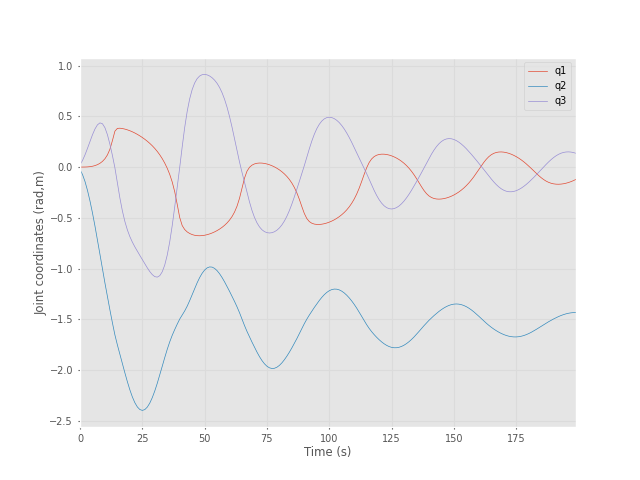

In [7]:
rtb.tools.trajectory.qplot(np.array(robot_state["q"]))

### 2.4 Observe Robot's Behaviour

<IPython.core.display.Javascript object>


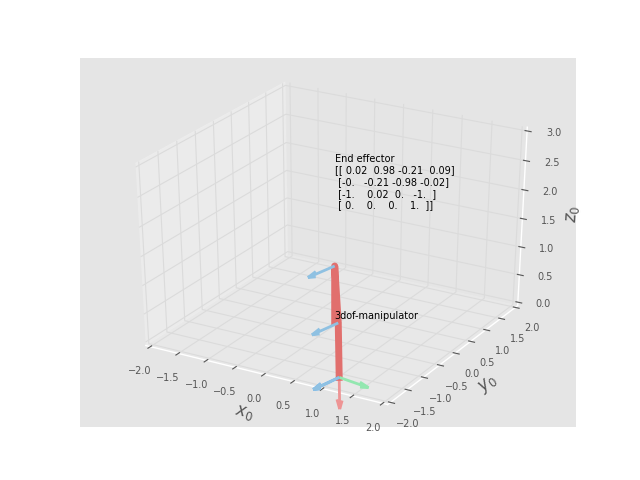

In [8]:
# Create visualization context
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-2.0, 2.0)
ax.set_ylim3d(-2.0, 2.0)
ax.set_zlim3d(0.0, 3.0)
ax.set_xlabel(r'$x_0$', fontsize=12)
ax.set_ylabel(r'$y_0$', fontsize=12)
ax.set_zlabel(r'$z_0$', fontsize=12)

# Create visualizer instance
my_plot = RobotJupyterPlot(my_bot, ax, readonly=True)

# Get trajectory to plot
path_to_plot = np.array(robot_state["q"])

def init():
    my_plot.draw()
    return

def animate(i):
    if i < len(path_to_plot):
        my_bot.q = path_to_plot[i]
        my_plot.draw()
    return
    
ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=100, init_func=init,
                              repeat=False)

## 3. Gravity Compensation and Feedback Linearisation

Even with our PD controller, the tracking performance is not perfect, and it's hard to find the optimal PD gains. How can we improve our control algorithm?

Two possible improvements can be added:
1. Add the gravity component of torque to the output of our PD controller
2. Combine our PD controller with feedback linearisation and compute the required torque input for each time step

### 3.1 Gravity Compensation

To add gravity compensation we will use the function ``grav_bot.gravload()``. This function calculates the joint gravity loading of the robot in the current joint configuration.

**TODO**: Extend the torque computation step (line 27) to include the torques due to gravity

**Interact**: 
- Test our new controller with different desired states. Here is an example of how to define a new desired state
```python
desired_state = np.r_[np.array([np.pi/2, 0, -np.pi/2]), np.zeros(grav_bot.n)]
```
- Observe what happens when the gains $K_p$ and $K_p$ change. Here is an example of how to manually define these gains
```python
K_p=[1.0, 1.0, 1.0]
K_d=[0.01, 0.01, 0.01]
```
If the gains are set manually, do not forget to comment out line 13

In [9]:
# Make a copy of our robot and define useful states
grav_bot = my_bot.copy()
grav_bot.qz = np.array([0,0,0]) # zero angles
grav_bot.qr = np.array([0, np.pi/2, 0]) # ready pose, arm up
grav_bot.qs = np.array([0, 0, np.pi/2]) # straight and elbow up

# Define desired state. We want the robot to be on the ready state, arm up with zero velocity
desired_state = np.r_[grav_bot.qr, np.zeros(grav_bot.n)]

# Set initial robot state
grav_bot.q = grav_bot.qz
grav_bot.qd = np.zeros((1,grav_bot.n))
grav_bot.qdd = np.zeros((1,grav_bot.n))

# Define time step
dt = 0.05

# Compute gain
K_p, K_d = define_pd_gains(grav_bot, w=100)

# Create a PID controller
pd_control = PD(desired_state=desired_state, K_p=K_p, K_d=K_d)

# Variables needed for plotting
grav_robot_state = {'q': [], 'qd': []}

# Number of iterations control loop
max_iterations = 400

# This is our control loop
for i in range(max_iterations):
        
    #TODO: Combine PD controller and gravity compensation torque outputs
    tau = np.zeros((1, grav_bot.n))
    
    # Compute acceleration
    new_qdd = grav_bot.accel(grav_bot.q, grav_bot.qd, tau)
    
    # Compute new states
    new_qd = grav_bot.qd + new_qdd * dt
    new_q = grav_bot.q + new_qd * dt
    
    # Assign new state to robot
    grav_bot.q = new_q
    grav_bot.qd = new_qd
    grav_bot.qdd = new_qdd
    
    grav_robot_state["q"].append(grav_bot.q)
    grav_robot_state["qd"].append(grav_bot.qd)

#### 3.1.1 Plot Robot's Trajectory

<IPython.core.display.Javascript object>


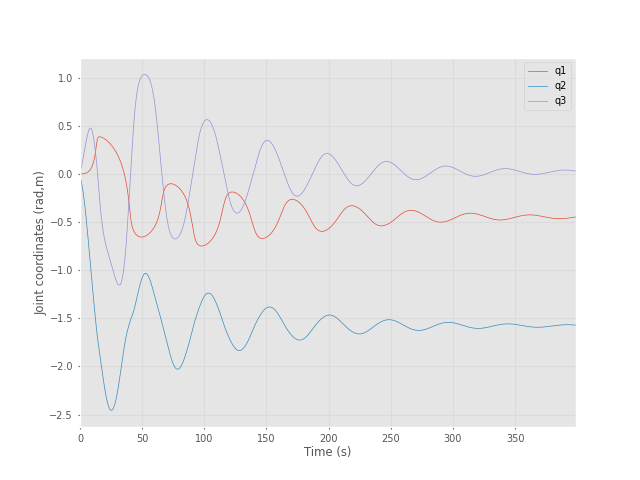

In [10]:
rtb.tools.trajectory.qplot(np.array(grav_robot_state["q"]))

#### 3.1.2 Observe Robot's Behaviour

Does our robot reach the desired state?

<IPython.core.display.Javascript object>


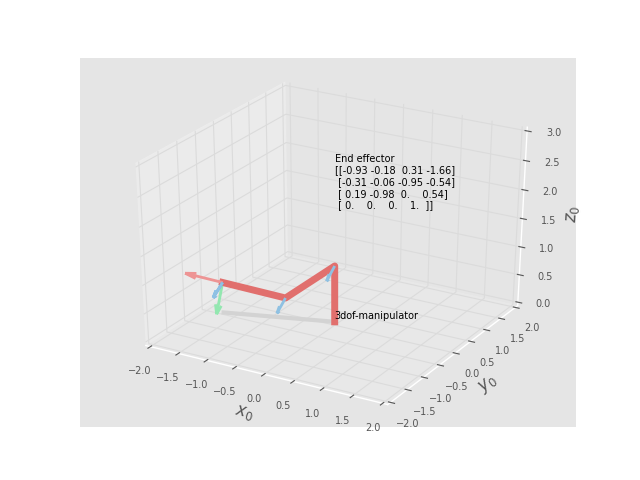

In [11]:
# Create visualization context
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-2.0, 2.0)
ax.set_ylim3d(-2.0, 2.0)
ax.set_zlim3d(0.0, 3.0)
ax.set_xlabel(r'$x_0$', fontsize=12)
ax.set_ylabel(r'$y_0$', fontsize=12)
ax.set_zlabel(r'$z_0$', fontsize=12)

# Set bot back to initial state
grav_bot.q = grav_bot.qz
# Create visualizer instance
my_plot = RobotJupyterPlot(grav_bot, ax, readonly=True)

# Get trajectory to plot
path_to_plot = np.array(grav_robot_state["q"])

def init():
    my_plot.draw()
    return

def animate(i):
    if i < len(path_to_plot):
        grav_bot.q = path_to_plot[i]
        my_plot.draw()
    return
    
ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=100, init_func=init,
                              repeat=False)

### 3.2 Feedback Linearisation

To add feedback linearisation we will:
1. Use our PD controller to compute the desired acceleration
2. Use inverse dynamics (i.e.,  function ``feed_bot.rne(q, qd, qdd)``) to calculate the joint torques required for the robot to achieve a desired configuration $[q, qd, qdd]$, with $qdd$ being the desired acceleration

**TODO**: Given the desired acceleration ``d_acc``, use inverse dynamics to compute the required torque input (line 32)

**Interact**: 
- Test our new controller with different desired states. Here is an example of how to define a new desired state
```python
desired_state = np.r_[np.array([np.pi/2, 0, -np.pi/2]), np.zeros(feed_bot.n)]
```
- Observe what happens when the gains $K_p$ and $K_p$ change. Here is an example of how to manually define these gains
```python
K_p=[1.0, 1.0, 1.0]
K_d=[0.01, 0.01, 0.01]
```

In [14]:
# Make a copy of our robot and define useful states
feed_bot = my_bot.copy()
feed_bot.qz = np.array([0,0,0]) # zero angles
feed_bot.qr = np.array([0, np.pi/2, 0]) # ready pose, arm up
feed_bot.qs = np.array([0, 0, np.pi/2]) # straight and elbow up

# Define desired state. We want the robot to be on the ready state, arm up with zero velocity
desired_state = np.r_[feed_bot.qr, np.zeros(feed_bot.n)]

# Set initial robot state
feed_bot.q = feed_bot.qz
feed_bot.qd = np.zeros((1,feed_bot.n))
feed_bot.qdd = np.zeros((1,feed_bot.n))

# Define time step
dt = 0.05

# Define the proportional and derivative gains
K_p = [2., 2., 2.]
K_d = [10.,25.,25.]

# Create a PD controller
pd_control = PD(desired_state=desired_state, K_p=K_p, K_d=K_d)

# Variables needed for plotting
feed_robot_state = {'q': [], 'qd': [], 'tau': []}

# Number of iterations in control loop
max_iterations = 2000

# This is our control loop
for i in range(max_iterations):
        
    # Compute desired acceleration
    d_acc = pd_control.compute_control(feed_bot)
    
    # TODO: Use inverse dynamics to compute new torque input
    tau = np.zeros((1, feed_bot.n))
           
    # Apply forward dynamics
    new_qdd = feed_bot.accel(feed_bot.q, feed_bot.qd, tau)
    
    # Compute new states
    new_qd = feed_bot.qd + new_qdd * dt
    new_q = feed_bot.q + new_qd * dt

    # Assign new state to robot
    feed_bot.q = new_q
    feed_bot.qd = new_qd
    feed_bot.qdd = new_qdd
   
    # Keep track of results for plotting
    feed_robot_state["q"].append(feed_bot.q)
    feed_robot_state["qd"].append(feed_bot.qd)
    feed_robot_state["tau"].append(tau)

#### 3.2.1 Plot Robot's Trajectory

<IPython.core.display.Javascript object>


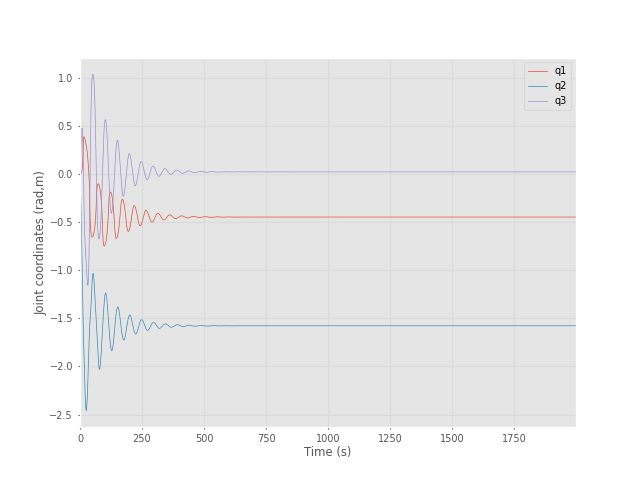

In [15]:
rtb.tools.trajectory.qplot(np.array(feed_robot_state["q"]))

#### 3.2.2 Observe Robot's Behaviour

Does our robot reach the desired state?

<IPython.core.display.Javascript object>


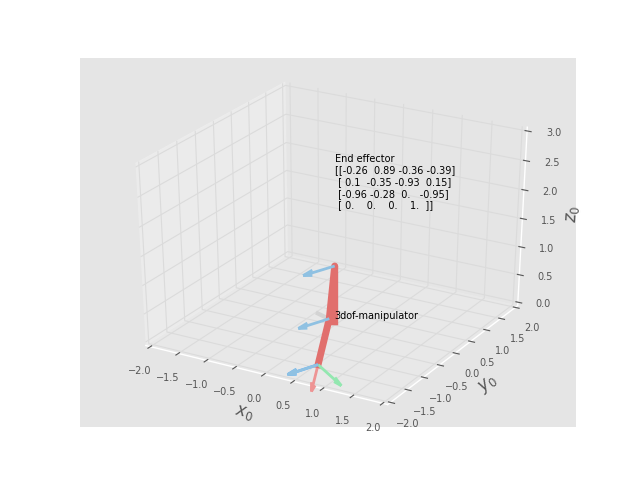

In [16]:
# Create visualization context
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-2.0, 2.0)
ax.set_ylim3d(-2.0, 2.0)
ax.set_zlim3d(0.0, 3.0)
ax.set_xlabel(r'$x_0$', fontsize=12)
ax.set_ylabel(r'$y_0$', fontsize=12)
ax.set_zlabel(r'$z_0$', fontsize=12)

# Set robot back to initial state
feed_bot.q = feed_bot.qz
# Create visualizer instance
my_plot = RobotJupyterPlot(feed_bot, ax, readonly=True)

# Get trajectory to plot
path_to_plot = np.array(feed_robot_state["q"])

def init():
    my_plot.draw()
    return

def animate(i):
    if i < len(path_to_plot):
        feed_bot.q = path_to_plot[i]
        my_plot.draw()
    return
    
ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=100, init_func=init,
                              repeat=False)